The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Commodity price (¢/m³),Gas cost adjustment (¢/m³),Effective price (¢/m³) *
Date,,,
2023-04-01,13.2318,2.0386,15.2704
2023-01-01,21.2666,1.7667,23.0333
2022-10-01,27.6575,0.2452,27.9027
2022-07-01,27.6752,-0.8072,26.8680
2022-04-01,18.3745,-0.6652,17.7093


Text(0, 0.5, '¢/m³')

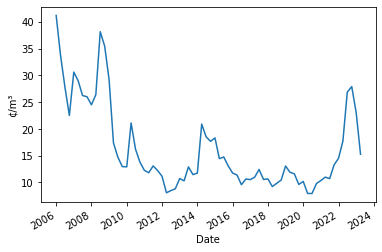

In [422]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.path.join(".."))

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_gas = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/oeb.ca/natural%20gas/Enbridge%20Gas.csv", index_col=0)
df_gas.index = pd.to_datetime(df_gas.index)
display(df_gas.head())
df_gas["Effective price (¢/m³) *"].plot()
plt.ylabel("¢/m³")


,Off-Peak price (¢ per kWh),Mid-Peak price (¢ per kWh),On-Peak price (¢ per kWh)
Effective date,,,
2022-11-01,7.4,10.2,15.1
2022-02-08,8.2,11.3,17.0
2022-01-18,8.2,8.2,8.2
2021-11-01,8.2,11.3,17.0
2021-05-01,8.2,11.3,17.0


Text(0, 0.5, '¢/m³')

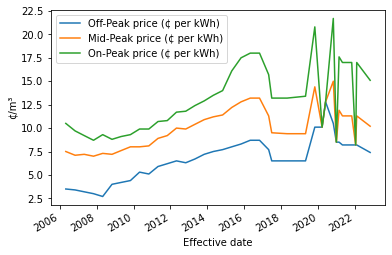

In [424]:
df_electricity = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/oeb.ca/electricity/Time-of-Use%20(TOU)%20rates.csv", index_col=0)
df_electricity.index = pd.to_datetime(df_electricity.index)
display(df_electricity.head())
df_electricity.plot()
plt.ylabel("¢/kWh")
